#**Airline Passengers Tickets Sales Prediction using Time Series Forecasting-**

### **Problem Statement**

The objective of this project is to implement and  explore different Time series Forecasting techniques like **ARIMA, SARIMA, PROPHET and XGBOOST** on a relatively simple and clean dataset. 
 

**Importing the necessary libraries-**

In [2]:
# import packages
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
!pip install pmdarima
from pmdarima.arima import auto_arima
from prophet import Prophet

# for calculation
from math import sqrt
from sklearn.metrics import mean_squared_error

# to plot within notebook
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 14.0 MB/s 
     |████████████████████████████████| 9.8 MB 40.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


**Loading the dataset-**

In [ ]:
colnames=["month", "passengers"] 
df = pd.read_csv("/content/Airlines Passenger.csv", nrows=144, names=colnames, header=0)

In [ ]:
df

,month,passengers
0,1949-02,118
1,1949-03,132
2,1949-04,129
3,1949-05,121
4,1949-06,135
...,...,...
138,1960-08,606
139,1960-09,508
140,1960-10,461
141,1960-11,390


**Implementing Augmented Dickey–Fuller (ADF) test to check the stationarity of data-**

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.passengers.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.792340
p-value: 0.991512


**Since p-value(0.991512) is greater than the significance level(0.05), so the data is non-stationary. Now, let’s difference the series and see how the autocorrelation plot looks like.**

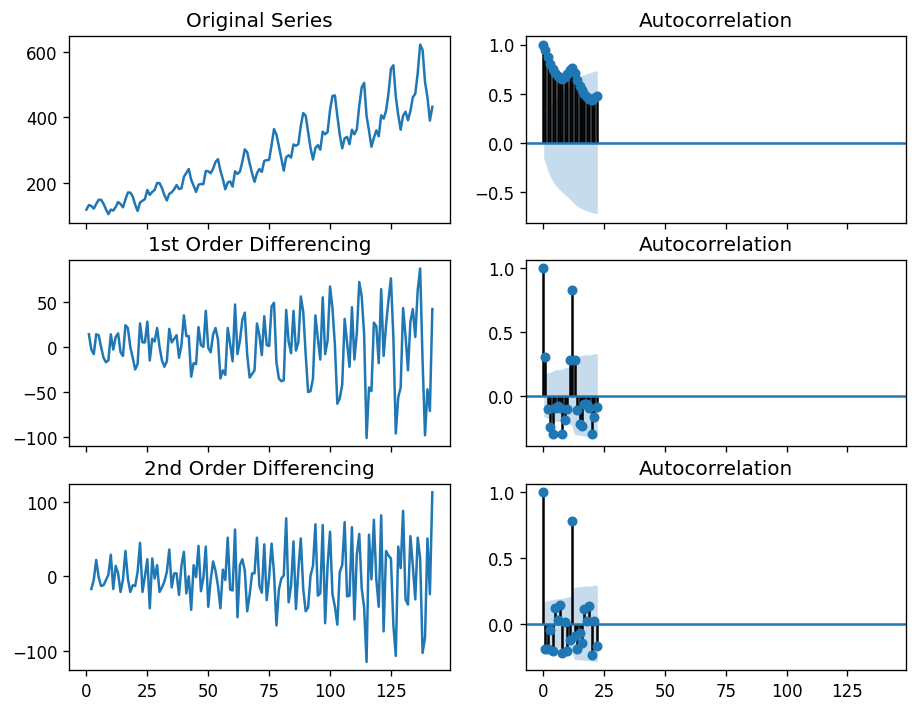

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.passengers); axes[0, 0].set_title('Original Series')
plot_acf(df.passengers, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.passengers.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.passengers.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.passengers.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.passengers.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

**For the above data, we can see that the time series reaches stationarity with two orders of differencing.**

**Finding the order of the AR term (p)-**

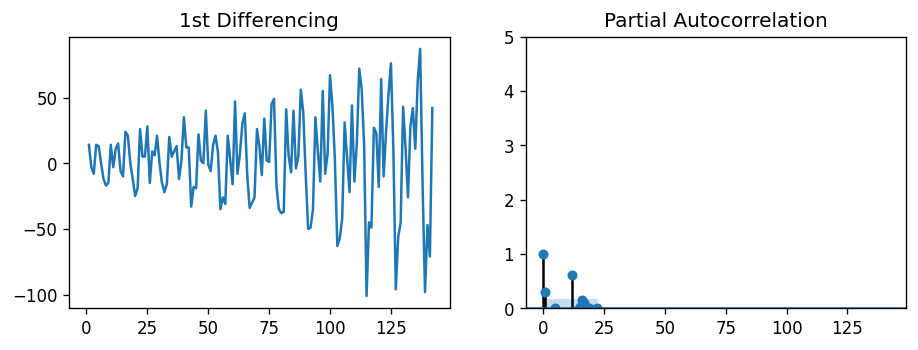

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.passengers.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.passengers.diff().dropna(), ax=axes[1])

plt.show()

**We can see that the PACF lag 1 is quite significant since it is well above the significance line. So, we will fix the value of p as 1.**


**Finding the order of the MA term (q)-**

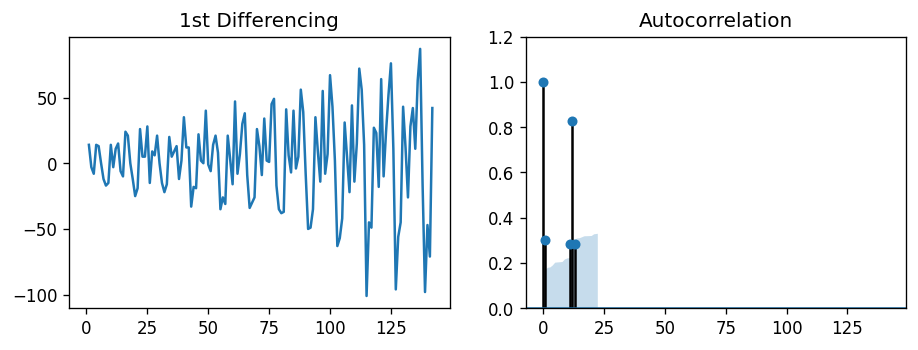

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.passengers.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.passengers.diff().dropna(), ax=axes[1])

plt.show()

**We can see that couple of lags are well above the significance line. So, we will fix q as 2. If there is any doubt, we will go with the simpler model that sufficiently explains the Y.**

**Building the ARIMA Model-**

# **ARIMA-**

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.passengers, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.passengers   No. Observations:                  142
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -676.613
Method:                       css-mle   S.D. of innovations             28.001
Date:                Sat, 13 Aug 2022   AIC                           1363.227
Time:                        10:03:38   BIC                           1378.006
Sample:                             1   HQIC                          1369.233
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.6602      0.183     14.516      0.000       2.301       3.019
ar.L1.D.passengers     0.5158      0.098      5.240      0.000       0.323       0.709
ma.L1.D.passengers  

1. The model summary provides lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

In [ ]:
# 1,1,1 ARIMA Model
model = ARIMA(df.passengers, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.passengers   No. Observations:                  142
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -692.701
Method:                       css-mle   S.D. of innovations             31.448
Date:                Sat, 13 Aug 2022   AIC                           1393.402
Time:                        10:03:38   BIC                           1405.225
Sample:                             1   HQIC                          1398.206
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.6137      0.231     11.296      0.000       2.160       3.067
ar.L1.D.passengers     0.7398      0.058     12.715      0.000       0.626       0.854
ma.L1.D.passengers  

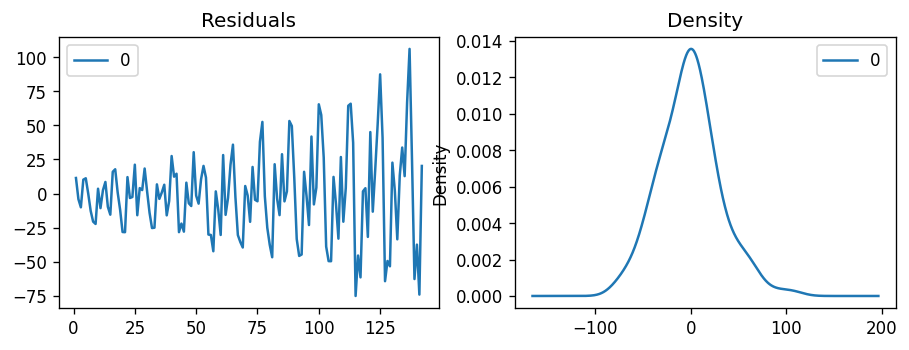

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

**The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using plot_predict().**

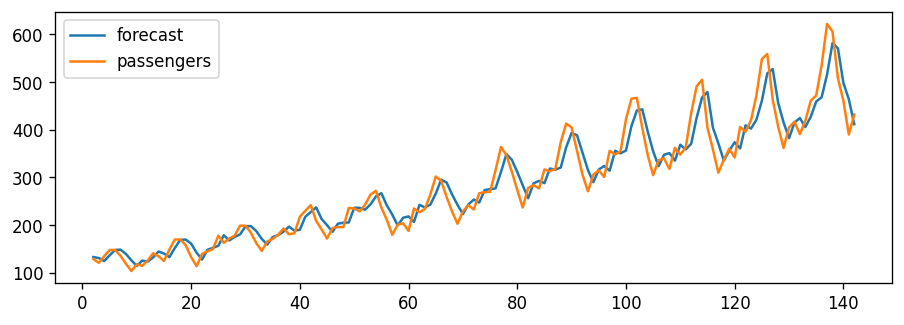

In [ ]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

1. When we set dynamic=False the in-sample lagged values are used for prediction. That is, the model gets trained up until the previous value to make the next prediction. This can make the fitted forecast and actuals look artificially good.
2. So, we seem to have a decent ARIMA model. But, we can’t say that this is the best ARIMA model because we haven’t actually forecasted into the future and compared the forecast with the actual performance.
3. So, the real validation we need now is the Out-of-Time cross-validation, discussed next.

**Find the optimal ARIMA model using Out-of-Time Cross validation** 

In Out-of-Time cross-validation, we move backwards in time and forecast into the future to as many steps we took back. Then we compare the forecast against the actuals.

To do so, we will create the training and testing dataset by splitting the time series into 2 contiguous parts in a reasonable proportion based on time frequency of series.

In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.passengers[:72]
test = df.passengers[72:]

In [ ]:
train

0     118
1     132
2     129
3     121
4     135
     ... 
67    259
68    229
69    203
70    229
71    242
Name: passengers, Length: 72, dtype: int64

In [ ]:
test.shape

(71,)

**Now, we will build the ARIMA model on training dataset, forecast and plot it.**

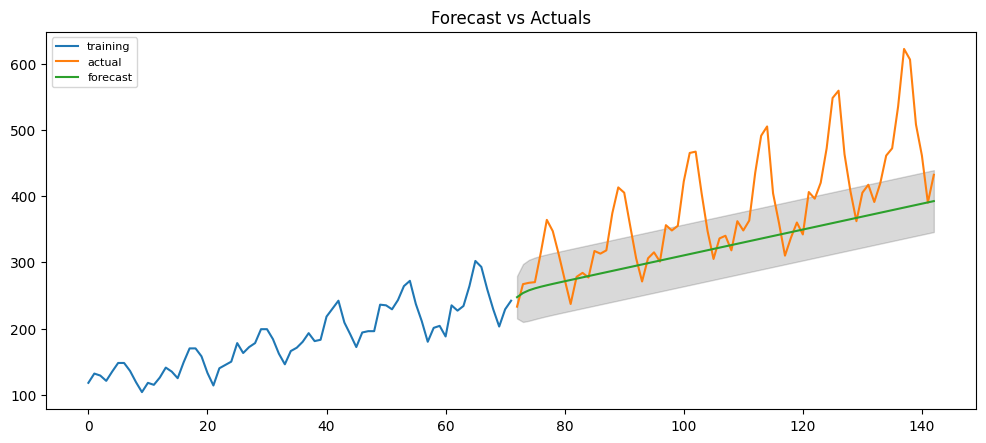

In [ ]:
# Build Model
# model = ARIMA(train, order=(1,1,2))  
model = ARIMA(train, order=(1, 1, 2))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(71, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

1. From the above chart, the ARIMA(1,1,2) model seems to predict a correct forecast. The actual observed values lie within the 95% confidence band.

2. But, we can see that the predicted forecasts is consistently below the actuals. That means, by adding a small constant to our forecast, the accuracy will certainly improve.

3. So, in this case, we should increase the order of differencing to two (d=3) and iteratively increase p and q up to 5 to see which model gives least AIC and also look for a chart that gives closer actuals and forecasts.

4. While doing this, I keep an eye on the P values of the AR and MA terms in the model summary. They should be as close to zero, ideally, less than 0.05.

                             ARIMA Model Results                              
Dep. Variable:          D2.passengers   No. Observations:                   70
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -303.596
Method:                       css-mle   S.D. of innovations             17.828
Date:                Sat, 13 Aug 2022   AIC                            621.191
Time:                        10:03:39   BIC                            636.931
Sample:                             2   HQIC                           627.443
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0114      0.079     -0.144      0.886      -0.167       0.144
ar.L1.D2.passengers     0.1515      0.117      1.300      0.198      -0.077       0.380
ar.L2.D2.passeng

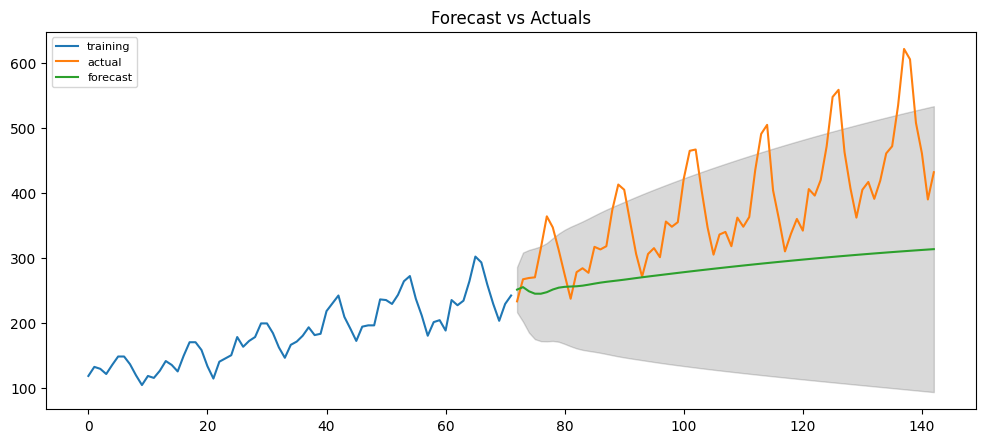

In [ ]:
# Build Model
model = ARIMA(train, order=(4,2,1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(71, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**The AIC has reduced to 621.191 from 1393.402 which is good.** 

**Accuracy Metrics for Time Series Forecast-** 

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  Returns


{'acf1': 0.7958129680543213,
 'corr': 0.711843325326997,
 'mae': 97.59541856623203,
 'mape': 0.23163749119537758,
 'me': -96.55554079505605,
 'minmax': 0.23147637907965546,
 'mpe': -0.22721294172844128,
 'rmse': 120.34447831745567}

**Around 23.16% MAPE implies the model is about 76.84% accurate in predicting the next 12 observations. Now we know how to build an ARIMA model manually.**

**Now, we will implement SARIMA model-**

# **SARIMA-**

In [3]:
colnames=["month", "passengers"] 
df = pd.read_csv("/content/Airlines Passenger.csv",nrows=144, names=colnames, header=0)

In [4]:
train = df.passengers[:72]
test = df.passengers[72:]

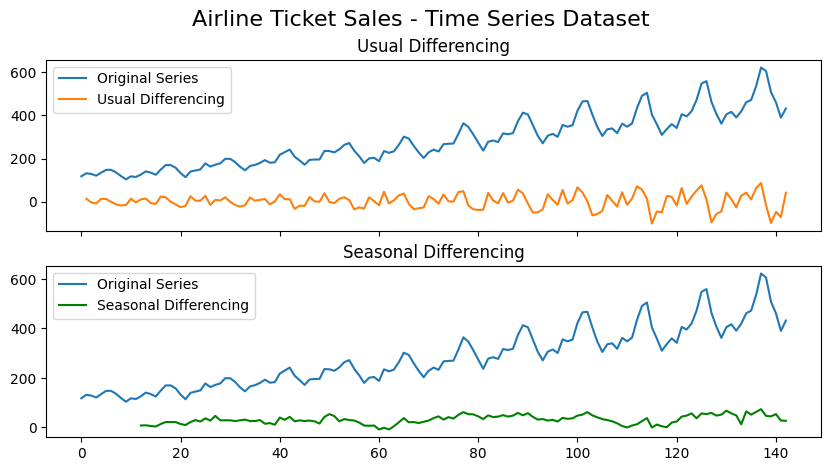

In [ ]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df.passengers, label='Original Series')
axes[0].plot(df.passengers.diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(df.passengers, label='Original Series')
axes[1].plot(df.passengers.diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Airline Ticket Sales - Time Series Dataset', fontsize=16)
plt.show()

We can see that, the seasonal spikes are intact after applying usual differencing (lag 1). Whereas, it is rectified after seasonal differencing.

Now, let’s build the SARIMA model using pmdarima‘s auto_arima(). To do so, we need to set seasonal=True, set the frequency m=12 for month wise series and enforce D=1.

**We can see that there is a seasonality trend in data of 12 months.**

In [6]:
import pmdarima as pm

In [7]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(df.passengers, start_p=1, start_q=1,
                         test='adf',
                         max_p=5, max_q=5, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1015.963, Time=0.44 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1024.482, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1013.464, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1014.083, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1013.428, Time=0.05 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1013.976, Time=0.26 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1013.430, Time=0.63 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1015.428, Time=0.07 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1015.428, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1013.689, Time=0.05 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1010.558, Time=0.42 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1010.702, Time=1.00 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1011.128, Time=1.05 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1010.829, Time=2.40 sec
 ARIMA(3,1,1)(0,1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  143
Model:             SARIMAX(2, 1, 1)x(0, 1, 0, 12)   Log Likelihood                -501.279
Date:                            Mon, 15 Aug 2022   AIC                           1010.558
Time:                                    14:39:06   BIC                           1022.028
Sample:                                         0   HQIC                          1015.218
                                            - 143                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5948      0.085      6.963      0.000       0.427       0.762
ar.L2          0.2132      0.092      2.311      0.021       0.032       0.394
ma.L1         -0.9842      0.039    -24.936      0.000      -1.062      -0.907
sigma2       129.6037     14.744      8.790      0.000     100.706     158.501
===================================================================================
Ljung-Box (Q):                       47.08   Jarque-Bera (JB):                 7.20
Prob(Q):                              0.21   Prob(JB):                         0.03
Heteroskedasticity (H):               2.37   Skew:                             0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

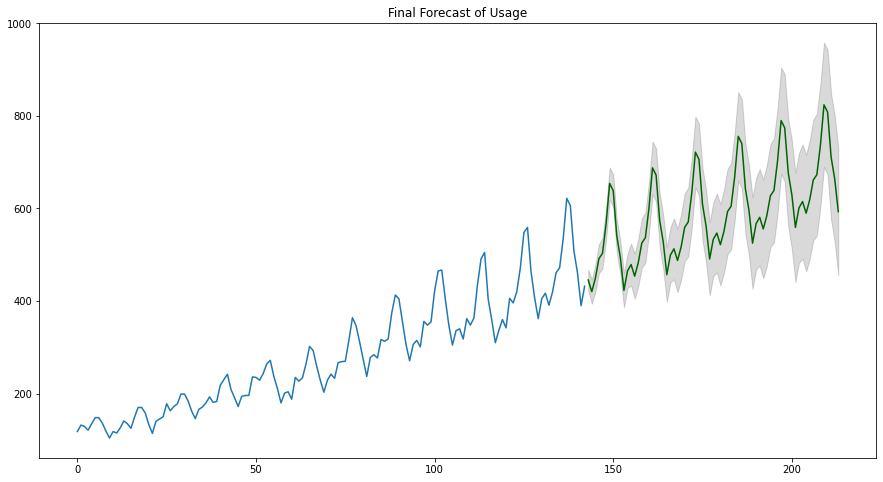

In [27]:
# Forecast
n_periods = 71
fc, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.passengers), len(df.passengers)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(15,8))
plt.plot(df.passengers)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Usage")
plt.show()

In [29]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    # acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':19.23, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})
    
forecast_accuracy(fc, test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':


{'corr': 0.8258987803070263,
 'mae': 212.22427596968691,
 'mape': 19.23,
 'me': 212.22427596968691,
 'minmax': 0.3608552842420658,
 'mpe': 0.588811574688155,
 'rmse': 219.0192281539167}

So, we are getting 19.23% MAPE value in our SARIMA model.

# **Prophet**

Prophet is open source software released by Facebook’s Core Data Science team. Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

By default Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast.

In [ ]:
# view the data
print(df.shape)
df.head()

(143, 2)


,month,passengers
0,1949-02,118
1,1949-03,132
2,1949-04,129
3,1949-05,121
4,1949-06,135


In [ ]:
# set index as Date
df["month"] = pd.to_datetime(df["month"])
df = df.set_index("month")
df.head()

,passengers
month,
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135


In [ ]:
# statistics
df.describe()

,passengers
count,143.000000
mean,281.475524
std,119.550851
min,104.000000
25%,180.500000
50%,267.000000
75%,361.000000
max,622.000000


In [ ]:
# group the passengers by year
df.groupby(df.index.year).sum()

,passengers
month,
1949,1408
1950,1676
1951,2042
1952,2364
1953,2700
1954,2867
1955,3408
1956,3939
1957,4421


In [ ]:
# group the passengers by year
df.groupby(df.index.year).count()

,passengers
month,
1949,11
1950,12
1951,12
1952,12
1953,12
1954,12
1955,12
1956,12
1957,12


In [ ]:
# calculate where to split the data
len(df[(df.index.year <= 1957)]), len(df[(df.index.year > 1957)])

(107, 36)

In [ ]:
# splitting into train and validation
train = df[:108]
valid = df[108:]

In [ ]:
train.shape, valid.shape

((108, 1), (35, 1))

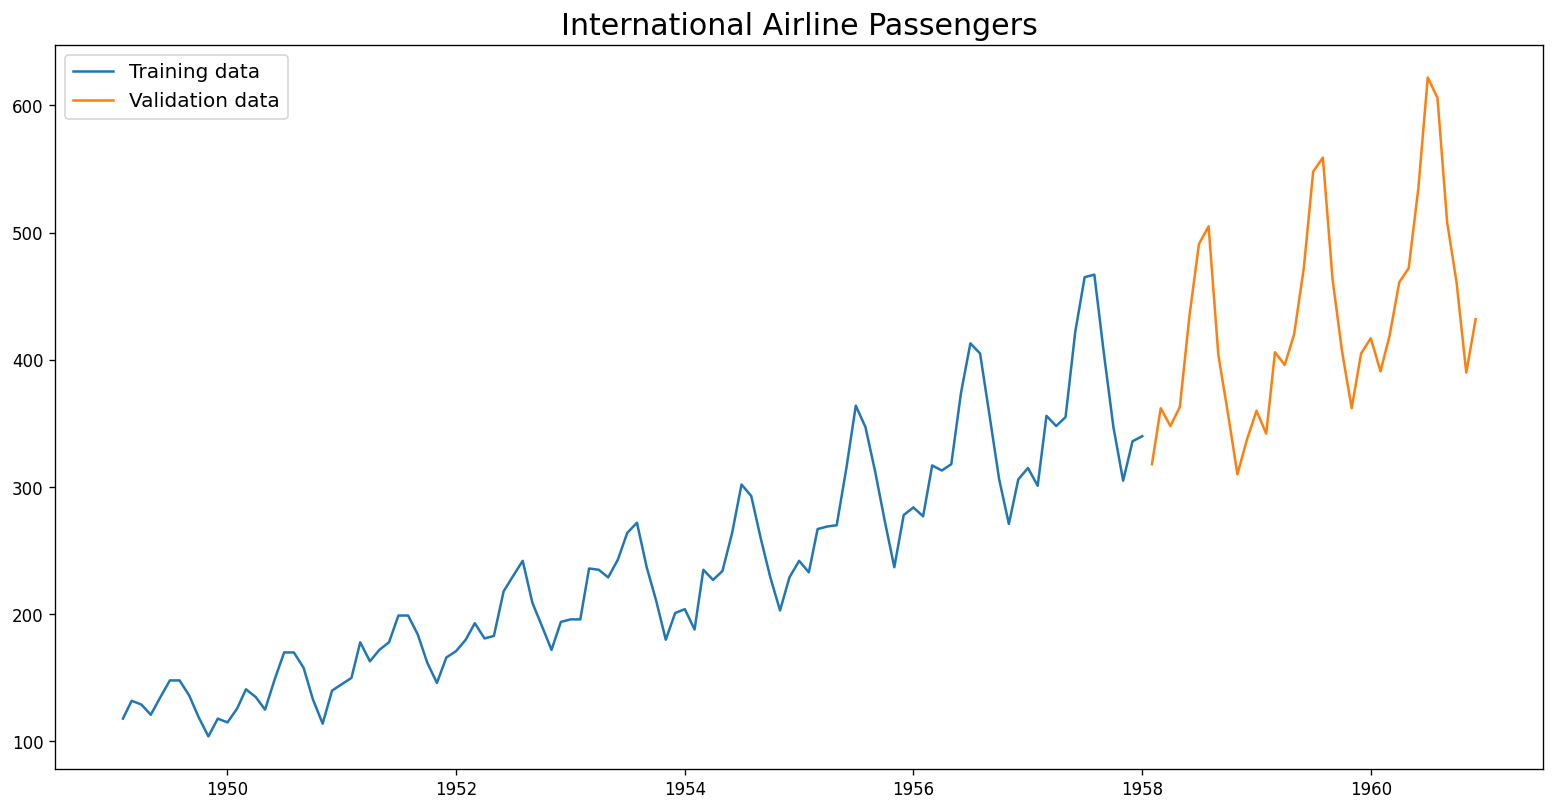

In [ ]:
# plot the graph
plt.figure(figsize=(16,8))
# plt.xlabel("Date")
# plt.ylabel("Passengers")
plt.title("International Airline Passengers", fontsize=18)
plt.plot(train.index, train["passengers"], label="Training data")
plt.plot(valid.index, valid["passengers"], label="Validation data")
plt.legend(prop={"size": 12})
plt.savefig("passengers.png", bbox_inches="tight")
plt.show()

In [ ]:
pd.options.mode.chained_assignment = None
train["ds"] = train.index
train[ "y"] = train.passengers
train.drop(["passengers"],axis = 1, inplace = True)

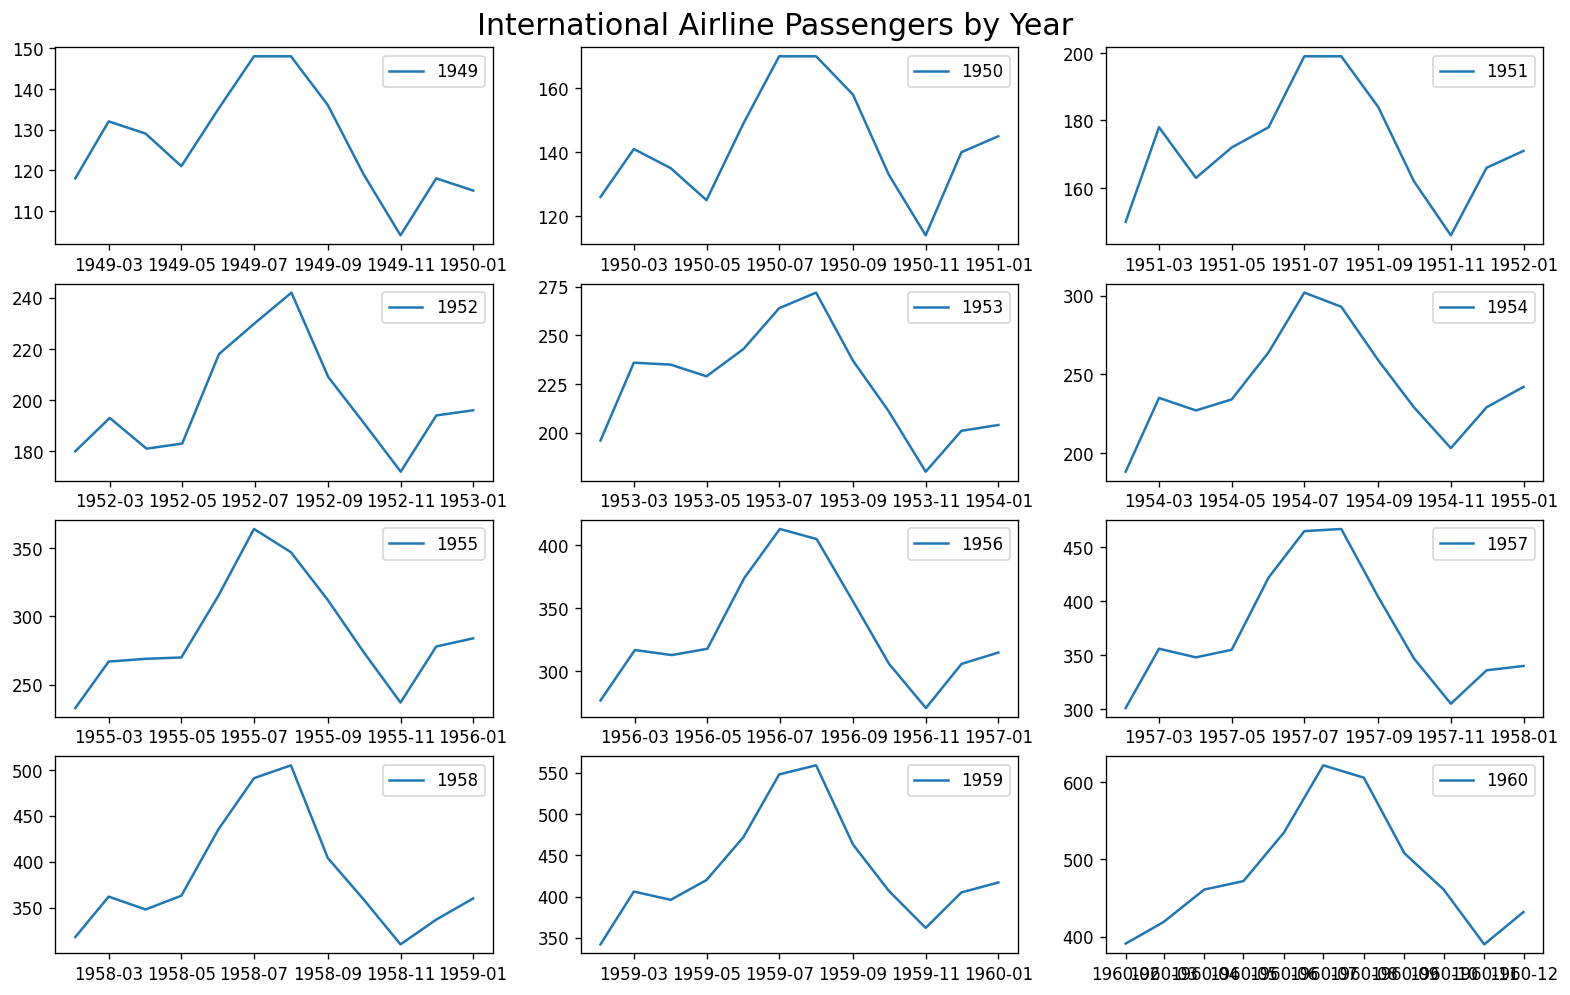

In [ ]:
# plot monthly data for seasonality

plt.subplots(figsize=(16,10))

plt.suptitle("International Airline Passengers by Year", fontsize=18, x=0.5, y=.91)

plt.subplot(431)
plt.plot(df.index[:12], df["passengers"][:12])
plt.legend(["1949"])

plt.subplot(432)
plt.plot(df.index[12:24], df["passengers"][12:24])
plt.legend(["1950"])

plt.subplot(433)
plt.plot(df.index[24:36], df["passengers"][24:36])
plt.legend(["1951"])

plt.subplot(434)
plt.plot(df.index[36:48], df["passengers"][36:48])
plt.legend(["1952"])

plt.subplot(435)
plt.plot(df.index[48:60], df["passengers"][48:60])
plt.legend(["1953"])

plt.subplot(436)
plt.plot(df.index[60:72], df["passengers"][60:72])
plt.legend(["1954"])

plt.subplot(437)
plt.plot(df.index[72:84], df["passengers"][72:84])
plt.legend(["1955"])

plt.subplot(438)
plt.plot(df.index[84:96], df["passengers"][84:96])
plt.legend(["1956"])

plt.subplot(439)
plt.plot(df.index[96:108], df["passengers"][96:108])
plt.legend(["1957"])

plt.subplot(4,3,10)
plt.plot(df.index[108:120], df["passengers"][108:120])
plt.legend(["1958"])

plt.subplot(4,3,11)
plt.plot(df.index[120:132], df["passengers"][120:132])
plt.legend(["1959"])

plt.subplot(4,3,12)
plt.plot(df.index[132:144], df["passengers"][132:144])
plt.legend(["1960"])

plt.savefig("by_year.png", bbox_inches="tight")
plt.show()

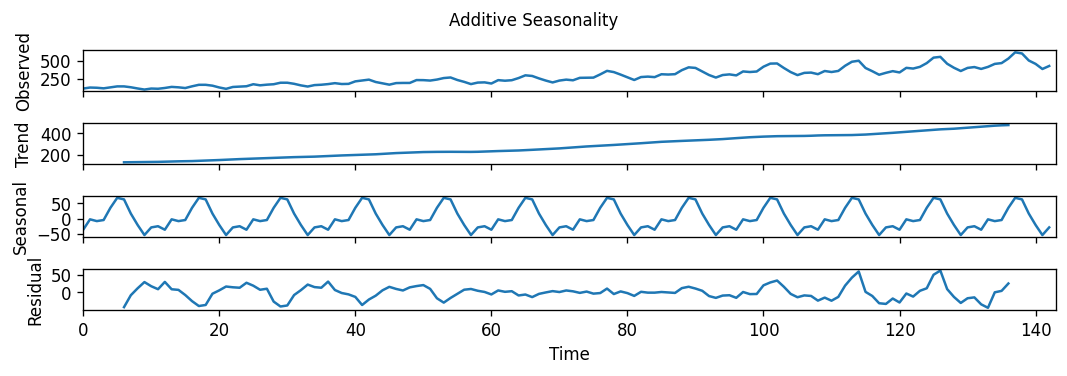

In [ ]:
# Additive Seasonality

add_seasonality = sm.tsa.seasonal_decompose(df.values,freq=12,model="additive")
fig = add_seasonality.plot()
fig.text(0.5, 0.99, "Additive Seasonality", ha="center")
plt.savefig("additive_seasonality.png", bbox_inches="tight")
plt.show()

In [ ]:
# fit the model
model = Prophet(seasonality_mode="additive")
model.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqghbaldh/l0urji7n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqghbaldh/ffva92ju.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11886', 'data', 'file=/tmp/tmpqghbaldh/l0urji7n.json', 'init=/tmp/tmpqghbaldh/ffva92ju.json', 'output', 'file=/tmp/tmpgbx0s7ds/prophet_model-20220813100407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# make predictions
future = model.make_future_dataframe(periods=len(valid), freq="M")
forecast = model.predict(future)

In [ ]:
# get the forecast values
forecast_valid = forecast["yhat"][108:]

In [ ]:
forecast_valid.shape, valid.shape

((35,), (35, 1))

In [ ]:
# insert prediction values into validation set
valid.insert(loc=1, column="prediction", value=forecast_valid.values)

In [ ]:
print(valid.shape)
valid.head()

(35, 2)


,passengers,prediction
month,,
1958-02-01,318,365.381995
1958-03-01,362,396.284205
1958-04-01,348,395.639199
1958-05-01,363,403.845877
1958-06-01,435,426.038480


In [ ]:
# calculate rmse
rms = np.sqrt(np.mean(np.power((np.array(valid["passengers"])-np.array(forecast_valid)),2)))
rms

44.18635257324287

In [ ]:
# calculate rmse
rms_prophet_as = sqrt(mean_squared_error(valid["passengers"], forecast_valid))
print("RMSE for Prophet = {}".format(rms_prophet_as))

RMSE for Prophet = 44.18635257324287


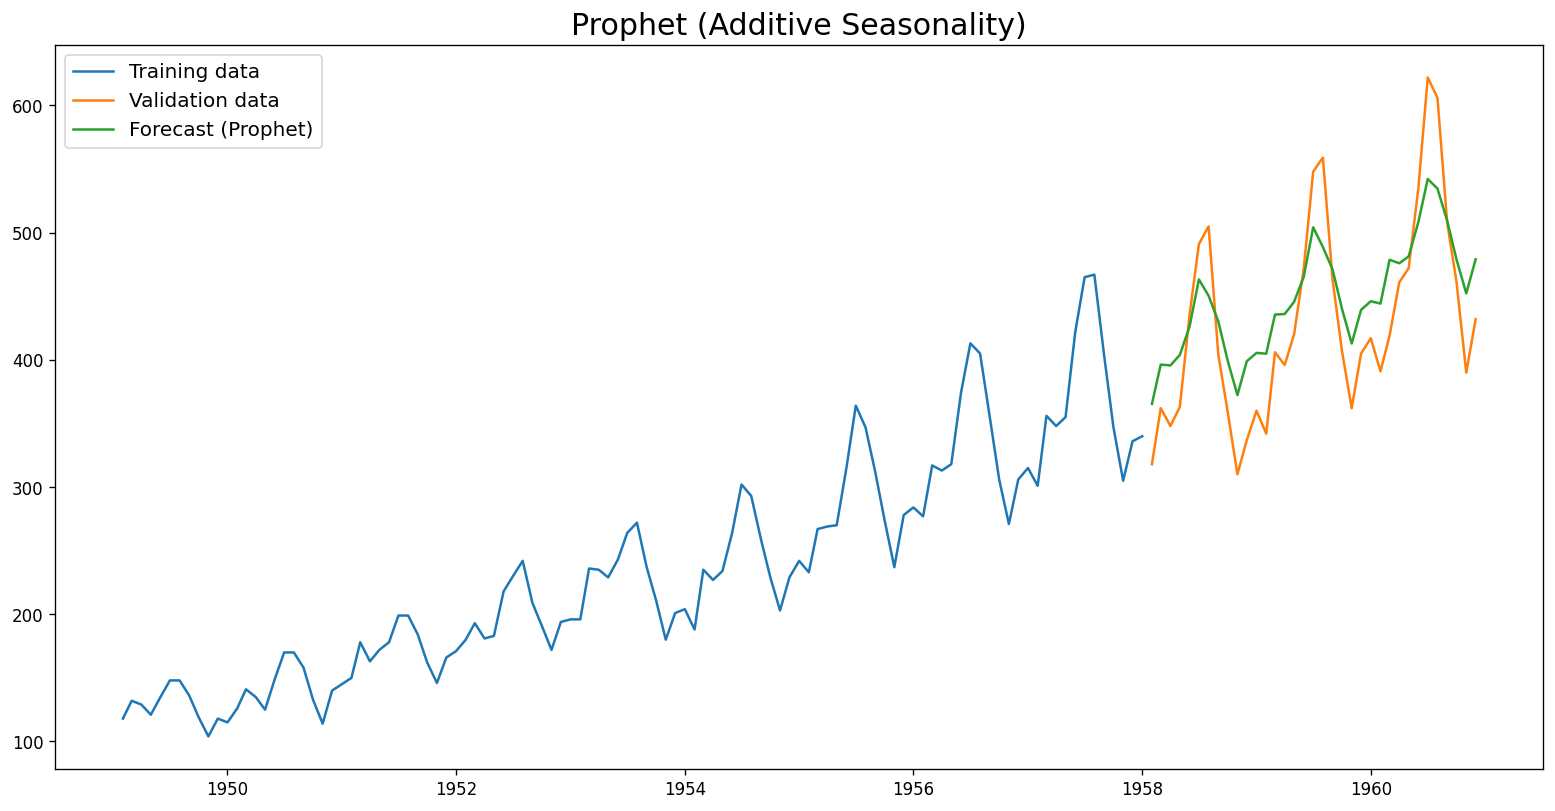

In [ ]:
# plot the result
plt.figure(figsize=(16,8))
# plt.xlabel("Date")
# plt.ylabel("Passengers")
plt.title("Prophet (Additive Seasonality)", fontsize=18)
plt.plot(train.index, train["y"], label="Training data")
plt.plot(valid.index, valid["passengers"], label="Validation data")
plt.plot(valid.index, valid["prediction"], label="Forecast (Prophet)")
plt.legend(prop={"size": 12})
plt.savefig("prophet_as.png", bbox_inches="tight")
plt.show()


**Multiplicative Seasonality**

This time series of the number of air passengers is an example of when additive seasonality does not work. This time series has a clear yearly cycle, but the seasonality in the forecast is too large at the start of the time series and too small at the end. In this time series, the seasonality is not a constant additive factor as assumed by Prophet, rather it grows with the trend. This is multiplicative seasonality. Prophet can model multiplicative seasonality by setting seasonality_mode='multiplicative' in the input arguments.


In [ ]:
# splitting into train and validation
train = df[:108]
valid = df[108:]
pd.options.mode.chained_assignment = None
train["ds"] = train.index
train[ "y"] = train.passengers
train.drop(["passengers"], axis = 1, inplace = True)

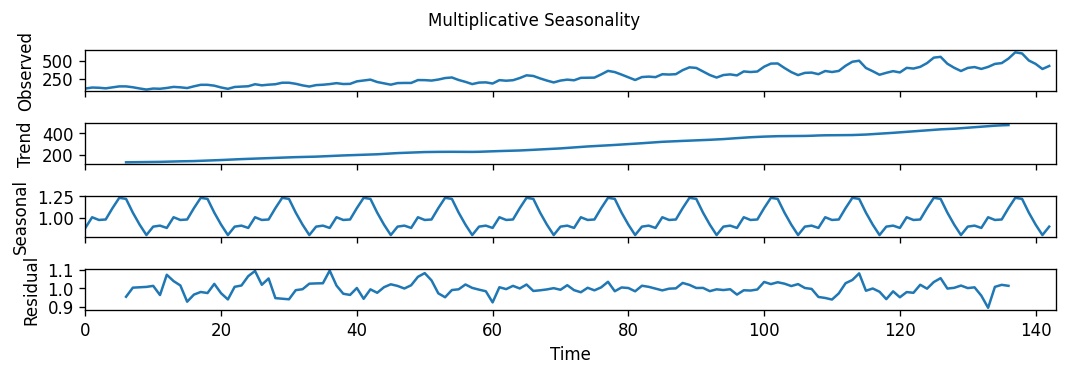

In [ ]:
# Multiplicative Seasonality

mul_seasonality = sm.tsa.seasonal_decompose(df.values,freq=12,model="multiplicative")
fig = mul_seasonality.plot()
fig.text(0.5, 0.99, "Multiplicative Seasonality", ha="center")
plt.savefig("multiplicative_seasonality.png", bbox_inches="tight")
plt.show()

In [ ]:
# fit the model
model = Prophet(seasonality_mode="multiplicative")
model.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqghbaldh/mg30zio7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqghbaldh/rcyq6i8r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7805', 'data', 'file=/tmp/tmpqghbaldh/mg30zio7.json', 'init=/tmp/tmpqghbaldh/rcyq6i8r.json', 'output', 'file=/tmp/tmphfa8l3xt/prophet_model-20220813100417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:04:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:04:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# make predictions
future = model.make_future_dataframe(periods=len(valid), freq="M")
forecast = model.predict(future)


In [ ]:
# get the forecast values
forecast_valid = forecast["yhat"][108:]

In [ ]:
# insert prediction values into validation set
valid.insert(loc=1, column="prediction", value=forecast_valid.values)

In [ ]:
# calculate rmse
rms = np.sqrt(np.mean(np.power((np.array(valid["passengers"])-np.array(forecast_valid)),2)))
rms

34.26903258866618

In [ ]:
# calculate rmse
rms_prophet_ms = sqrt(mean_squared_error(valid["passengers"], forecast_valid))
print("RMSE for Prophet = {}".format(rms_prophet_ms))

RMSE for Prophet = 34.26903258866618


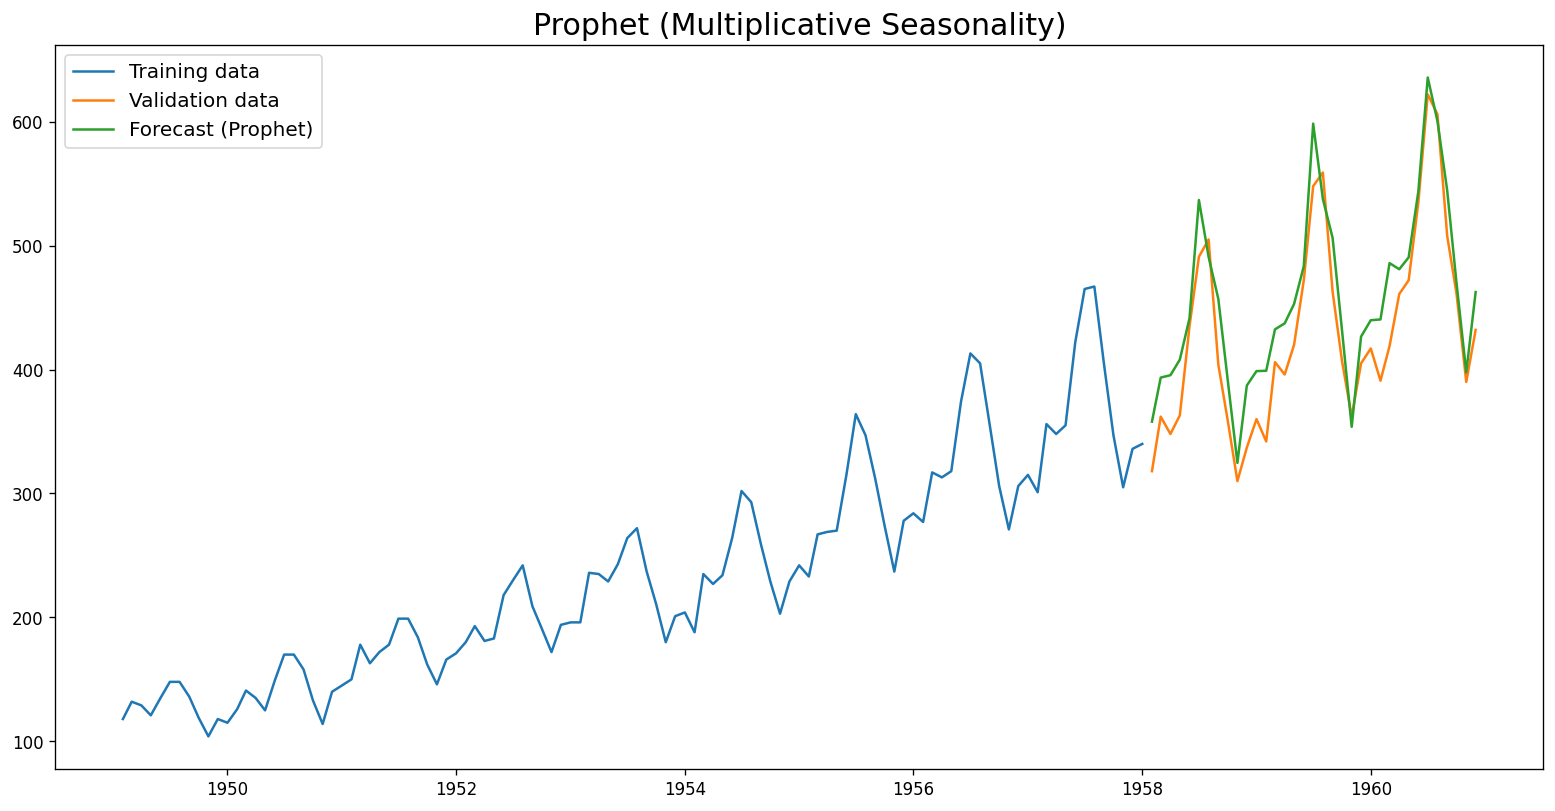

In [ ]:
# plot the result
plt.figure(figsize=(16,8))
# plt.xlabel("Date")
# plt.ylabel("Passengers")
plt.title("Prophet (Multiplicative Seasonality)", fontsize=18)
plt.plot(train.index, train["y"], label="Training data")
plt.plot(valid.index, valid["passengers"], label="Validation data")
plt.plot(valid.index, valid["prediction"], label="Forecast (Prophet)")
plt.legend(prop={"size": 12})
plt.savefig("prophet_ms.png", bbox_inches="tight")
plt.show()

**So, we see that the Prophet model with multiplicative seasonability gives better results with rms value of 34.27**

**Now, we will implement XGBOOST model of time forecasting-**

# **XGBOOST-**

In [ ]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
colnames=["month", "passengers"] 
df = pd.read_csv("/content/Airlines Passenger.csv", nrows=144, names=colnames, header=0)

In [ ]:
# set index as Date
df["month"] = pd.to_datetime(df["month"])
df = df.set_index("month")
df.head()

,passengers
month,
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135


In [ ]:
# group the passengers by year
df.groupby(df.index.year).sum()

,passengers
month,
1949,1408
1950,1676
1951,2042
1952,2364
1953,2700
1954,2867
1955,3408
1956,3939
1957,4421


In [ ]:
# group the passengers by year
df.groupby(df.index.year).count()

,passengers
month,
1949,11
1950,12
1951,12
1952,12
1953,12
1954,12
1955,12
1956,12
1957,12


In [ ]:
# calculate where to split the data
len(df[(df.index.year <= 1957)]), len(df[(df.index.year > 1957)])

(107, 36)

In [ ]:
train = df[:108]
valid = df[108:]

In [ ]:
X_train, y_train = create_features(train, label='passengers')
X_test, y_test = create_features(valid, label='passengers')
X_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
month,,,,,,,,
1949-02-01,0,1,1,2,1949,32,1,5
1949-03-01,0,1,1,3,1949,60,1,9
1949-04-01,0,4,2,4,1949,91,1,13
1949-05-01,0,6,2,5,1949,121,1,17
1949-06-01,0,2,2,6,1949,152,1,22
...,...,...,...,...,...,...,...,...
1957-09-01,0,6,3,9,1957,244,1,35
1957-10-01,0,1,4,10,1957,274,1,40
1957-11-01,0,4,4,11,1957,305,1,44


In [ ]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [ ]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

[10:04:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

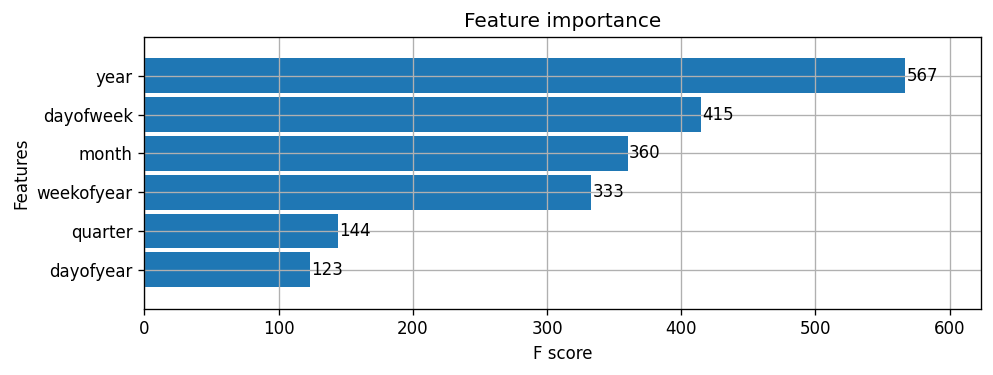

In [ ]:
plot_importance(reg, height=0.9)

In [ ]:
valid['passenger_Prediction'] = reg.predict(X_test)
data_all = pd.concat([valid, train], sort=False)

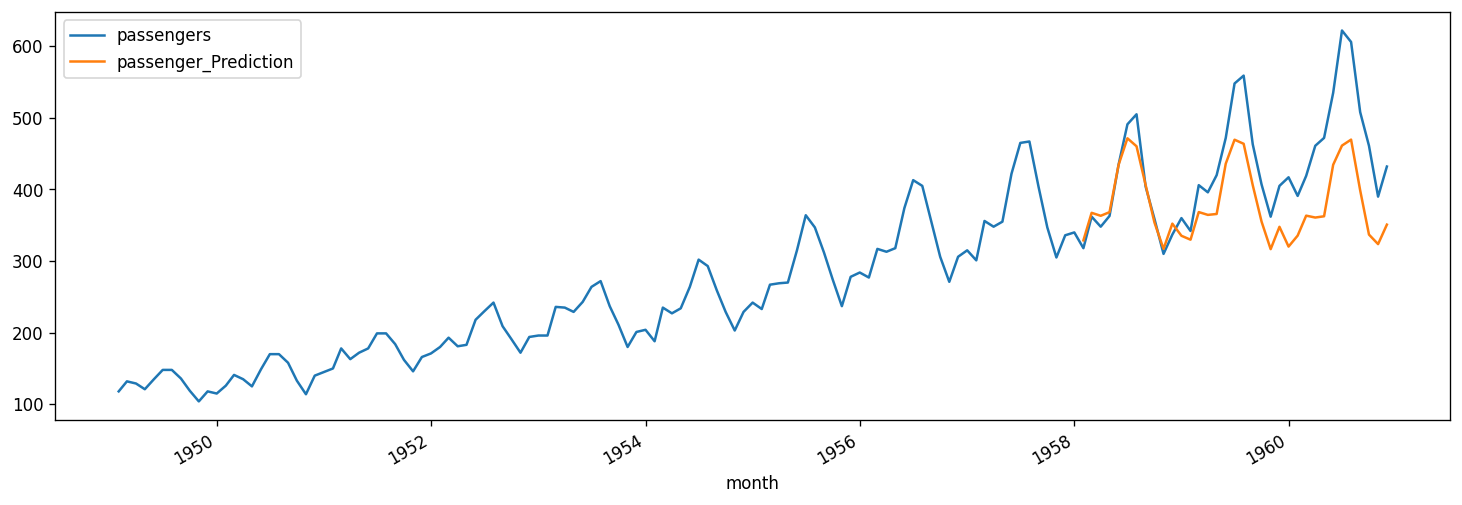

In [ ]:
data_all[['passengers','passenger_Prediction']].plot(figsize=(15, 5))

In [ ]:
mean_squared_error(y_true=valid['passengers'],
                   y_pred=valid['passenger_Prediction'])

4783.126755409395

In [ ]:
print("The RMSE value for prediction from XGBOOST model is= ",(mean_squared_error(y_true=valid['passengers'],
                   y_pred=valid['passenger_Prediction']))**0.5)

The RMSE value for prediction from XGBOOST model is=  69.16015294524293


In [ ]:
mean_absolute_error(y_true=valid['passengers'],
                   y_pred=valid['passenger_Prediction'])

54.532579694475444